In this notebook, we load our RNN models that we trained in advance into workspace, construct ensemble models for each target dates, and make predictions.

In [56]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from Scripts.functions import *
import keras
from keras.models import load_model

In [3]:
# Load dataset
data = pd.read_csv('../Data/ProductionData/Weather-Energy_rev_time_hourly_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8782 entries, 0 to 8781
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               8782 non-null   int64  
 1   day                      8782 non-null   int64  
 2   hour                     8782 non-null   int64  
 3   temperature              8782 non-null   float64
 4   wind_speed(m/s)          8782 non-null   float64
 5   humidity(%)              8782 non-null   float64
 6   solar_radiation(MJ/m^2)  8782 non-null   float64
 7   energy                   8782 non-null   float64
 8   time                     8782 non-null   object 
dtypes: float64(5), int64(3), object(1)
memory usage: 617.6+ KB


In [5]:
# Select few columns of interest
dataset = data.loc[:, ['day','hour','temperature','wind_speed(m/s)','humidity(%)','solar_radiation(MJ/m^2)','energy']]

In [6]:
# Set index as 'time'
dataset.index = data['time']

In [7]:
# Reverse humidity data
dataset['humidity(%)'] = 100 - dataset['humidity(%)']  

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba415524a8>,
      dtype=object)

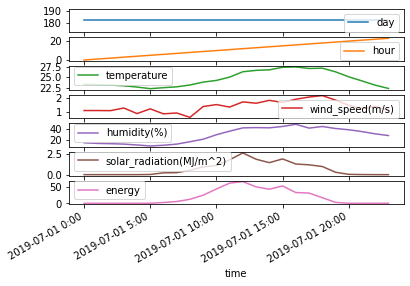

In [8]:
# Visualize the dataset
dataset[:24].plot(subplots = True)

In [29]:
# Load models
model_GRU_131 = load_model('../Data/Model/model_GRU_131.h5', custom_objects={'custom_loss' : custom_loss})
model_LSTM_131 = load_model('../Data/Model/model_LSTM_131.h5', custom_objects={'custom_loss' : custom_loss})

model_GRU_331 = load_model('../Data/Model/model_GRU_331.h5', custom_objects={'custom_loss' : custom_loss})
model_LSTM_331 = load_model('../Data/Model/model_LSTM_331.h5', custom_objects={'custom_loss' : custom_loss})

# model_GRU_531 = load_model('../Data/Model/model_GRU_531.h5', custom_objects={'custom_loss' : custom_loss})
model_GRU_531 = load_model('../Data/Model/gru_531_20200727.h5', custom_objects={'custom_loss' : custom_loss})
model_LSTM_531 = load_model('../Data/Model/model_LSTM_531.h5', custom_objects={'custom_loss' : custom_loss})

In [11]:
col_names = data.columns
print(col_names)

Index(['Unnamed: 0', 'day', 'hour', 'temperature', 'wind_speed(m/s)',
       'humidity(%)', 'solar_radiation(MJ/m^2)', 'energy', 'time'],
      dtype='object')


In [12]:
# Scaling function
def scale_data(dataset, x_scaler, y_scaler):
    data_X = dataset.loc[:, ['day','hour', 'temperature', 'wind_speed(m/s)','humidity(%)', 'solar_radiation(MJ/m^2)']]
    data_Y = dataset.iloc[:, -1]
    data_Y = data_Y.to_numpy()
    data_Y = np.reshape(data_Y, (-1, 1))
    data_X = x_scaler.fit_transform(data_X)
    data_Y = y_scaler.fit_transform(data_Y)
    
    return data_X, data_Y

In [13]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

data_X, data_Y = scale_data(dataset, x_scaler, y_scaler)

dataset = np.concatenate((data_X, data_Y), axis=1)

Fill NaN value using data from the same time of the previous day.

In [14]:
fill_nan_values(dataset)

In [15]:
# Generate data to predict January 31st energy production
start = data[data['time']=="2019-12-01 0:00"].index.tolist()[0]
end = data[data['time']=="2020-01-31 0:00"].index.tolist()[0]# %%
trainX_131, trainY_131 = generate_training_data(start, end, 1, 6, 1, dataset)

start2 = data[data['time']=="2020-02-01 0:00"].index.tolist()[0]
end2 = data[data['time']=="2020-03-31 0:00"].index.tolist()[0]
trainX_331, trainY_331 = generate_training_data(start2, end2, 1, 6, 1, dataset)

start3 = data[data['time']=="2020-04-01 0:00"].index.tolist()[0]
end3 = data[data['time']=="2020-05-31 0:00"].index.tolist()[0]
trainX_531, trainY_531 = generate_training_data(start3, end3, 1, 6, 1, dataset)


In [28]:
trainX_531.shape

(1320, 96, 7)

In [16]:
Inputs = keras.Input(shape=trainX_131.shape[-2:])

y0 = model_GRU_131(Inputs)
y1 = model_LSTM_131(Inputs)

output = keras.layers.average([y0, y1])
ensemble_model_131 = keras.Model(inputs=Inputs, outputs=output)
ensemble_model_131.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

ensemble_model_131.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 7)]      0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 24, 1)        189441      input_1[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 24, 1)        8901        input_1[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 24, 1)        0           sequential_7[1][0]               
                                                                 sequential_8[0][0]           

In [60]:
Inputs = keras.Input(shape=trainX_331.shape[-2:])

y0 = model_GRU_331(Inputs)
y1 = model_LSTM_331(Inputs)

output = keras.layers.average([y0, y1])
ensemble_model_331 = keras.Model(inputs=Inputs, outputs=output)
ensemble_model_331.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

ensemble_model_331.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 7)]      0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 24, 1)        189441      input_4[0][0]                    
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 24, 1)        8901        input_4[0][0]                    
__________________________________________________________________________________________________
average_2 (Average)             (None, 24, 1)        0           sequential_9[1][0]               
                                                                 sequential_10[0][0]        

To gain a little bit of more performance, we train our ensemble models again.

In [17]:
for i in range(50):
     x_train, y_train, x_val, y_val = split_data(trainX_131[:-1], trainY_131[:-1], 0.1)
     history = ensemble_model_131.fit(x_train, y_train, batch_size=64, epochs=1, validation_data = (x_val,y_val), verbose = 1)

19/19 [==============================] - 3s 132ms/step - loss: 5.2726e-04 - custom_loss: 0.0291 - val_loss: 7.3643e-04 - val_custom_loss: 0.0353


In [18]:
ensemble_model_131.save('ensemble_model_131.h5')

In [61]:
for i in range(50):
     x_train, y_train, x_val, y_val = split_data(trainX_331[:-1], trainY_331[:-1], 0.1)
     history = ensemble_model_331.fit(x_train, y_train, batch_size=64, epochs=1, validation_data = (x_val,y_val), verbose = 1)

19/19 [==============================] - 2s 116ms/step - loss: 0.0016 - custom_loss: 0.0475 - val_loss: 0.0016 - val_custom_loss: 0.0575


In [62]:
ensemble_model_331.save('ensemble_model_331.h5')

In [30]:
Inputs = keras.Input(shape=trainX_531.shape[-2:])

y0 = model_GRU_531(Inputs)
y1 = model_LSTM_531(Inputs)

output = keras.layers.average([y0, y1])
ensemble_model_531 = keras.Model(inputs=Inputs, outputs=output)
ensemble_model_531.compile(loss='mse', optimizer='adam', metrics= [custom_loss])

ensemble_model_531.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 7)]      0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 24, 1)        189441      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 24, 1)        8901        input_3[0][0]                    
__________________________________________________________________________________________________
average_1 (Average)             (None, 24, 1)        0           sequential_1[1][0]               
                                                                 sequential_12[0][0]        

In [31]:
for i in range(50):
     x_train, y_train, x_val, y_val = split_data(trainX_531[:-1], trainY_531[:-1], 0.1)
     history = ensemble_model_531.fit(x_train, y_train, batch_size=64, epochs=1, validation_data = (x_val,y_val), verbose = 1)

ensemble_model_531.save('ensemble_model_531.h5')

19/19 [==============================] - 2s 117ms/step - loss: 0.0048 - custom_loss: 0.0796 - val_loss: 0.0123 - val_custom_loss: 0.1112


In [19]:
ensemble_model_331 = load_model('../Notebooks/ensemble_model_331.h5', custom_objects={'custom_loss' : custom_loss})

In [20]:
prediction_131 = ensemble_model_131.predict(np.expand_dims(dataset[end-96:end], axis=0))

In [22]:
prediction_131 = y_scaler.inverse_transform(prediction_131[0])

Below are the plots of prediction made by models. To estimate their accuracy, we made them predict energy production of a day that we already have in our dataset. 

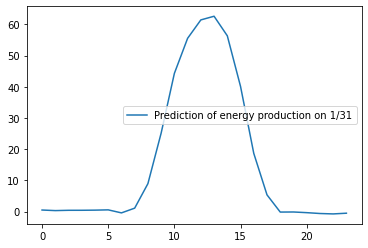

In [23]:
plt.plot(prediction_131, label='Prediction of energy production on 1/31')
plt.legend()
plt.show()

In [63]:
prediction = ensemble_model_331.predict(np.expand_dims(dataset[end2-96:end2], axis=0))
prediction

array([[[-2.7456637e-03],
        [-3.0567292e-03],
        [-3.7357304e-03],
        [-3.9878432e-03],
        [-1.4887471e-03],
        [ 9.3015842e-04],
        [ 4.4036601e-03],
        [ 2.4792040e-02],
        [ 1.3780209e-01],
        [ 3.5075220e-01],
        [ 5.6330699e-01],
        [ 7.2127330e-01],
        [ 7.9365832e-01],
        [ 7.7118528e-01],
        [ 6.6545641e-01],
        [ 4.8493677e-01],
        [ 2.4695632e-01],
        [ 5.2336589e-02],
        [ 6.8545397e-03],
        [-6.3746609e-04],
        [-1.3745818e-03],
        [-2.5117788e-03],
        [-2.0161066e-03],
        [ 6.9034658e-04]]], dtype=float32)

In [64]:
prediction = y_scaler.inverse_transform(prediction[0])

In [65]:
prediction

array([[-3.0429918e-01],
       [-3.3877423e-01],
       [-4.1402727e-01],
       [-4.4196868e-01],
       [-1.6499636e-01],
       [ 1.0308853e-01],
       [ 4.8805323e-01],
       [ 2.7476771e+00],
       [ 1.5272469e+01],
       [ 3.8873516e+01],
       [ 6.2430752e+01],
       [ 7.9937996e+01],
       [ 8.7960358e+01],
       [ 8.5469696e+01],
       [ 7.3751869e+01],
       [ 5.3745056e+01],
       [ 2.7369923e+01],
       [ 5.8004117e+00],
       [ 7.5968176e-01],
       [-7.0649728e-02],
       [-1.5234353e-01],
       [-2.7837795e-01],
       [-2.2344308e-01],
       [ 7.6510422e-02]], dtype=float32)

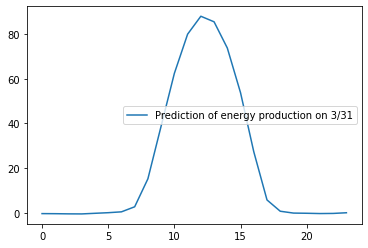

In [66]:
plt.plot(prediction, label='Prediction of energy production on 3/31')
plt.legend()
plt.show()

In [49]:
prediction_531 = ensemble_model_531.predict(np.expand_dims(dataset[end3-96:end3], axis=0))

In [50]:
prediction_531 = y_scaler.inverse_transform(prediction_531[0])

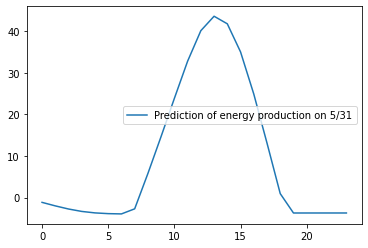

In [51]:
plt.plot(prediction_531, label='Prediction of energy production on 5/31')
plt.legend()
plt.show()

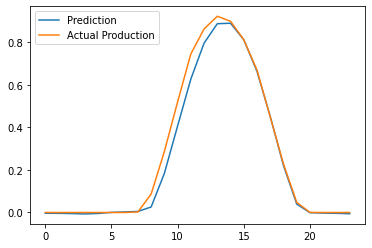

In [20]:
show_graph(len(trainX_331)-1, ensemble_model_331, trainX_331, trainY_331)

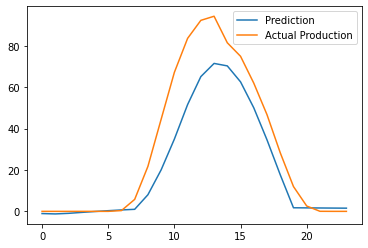

In [59]:
show_graph_t(len(trainX_531)-1, ensemble_model_531, trainX_531, trainY_531, y_scaler)